In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [36]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [37]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad", patient_id_col="patient_id")  # read a .h5ad file

2023-03-17 14:55:20,297 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/tutorial/diamandis.h5ad
2023-03-17 14:55:20,339 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [38]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [39]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [40]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040062,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684864e+14,3.112051e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638138,0.763087


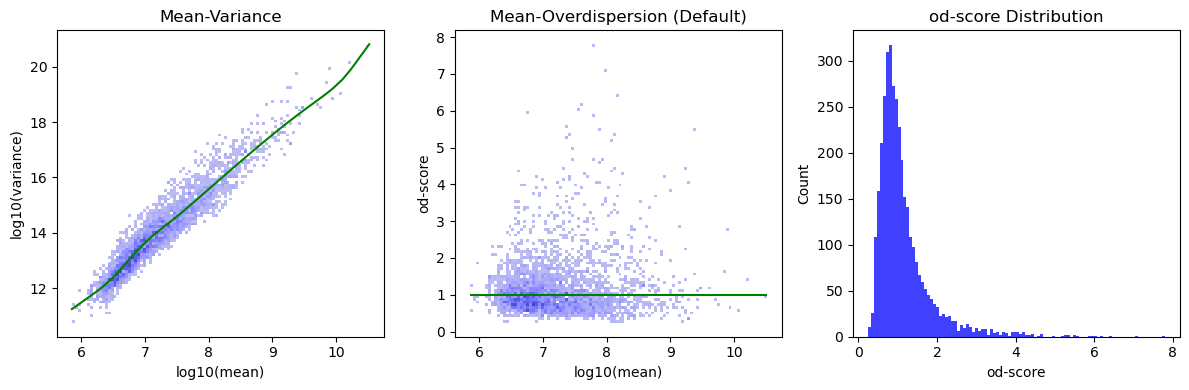

In [41]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-03-17 14:55:23,048 [INFO] 1612 genes selected for factorization


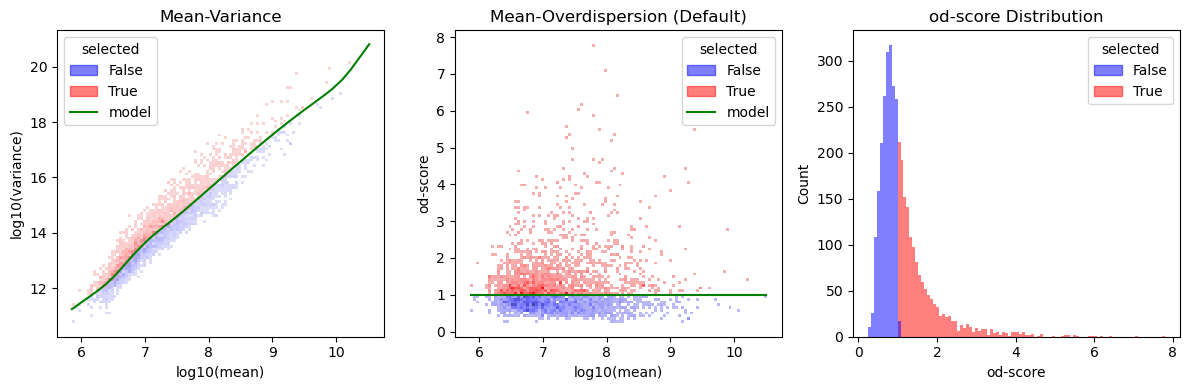

In [42]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [43]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [44]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-03-17 14:55:31,032 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-03-17 14:55:31,033 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-03-17 14:55:31,033 [INFO] Creating consensus GEPs and usages for k=2
2023-03-17 14:55:32,847 [INFO] Creating consensus GEPs and usages for k=3
2023-03-17 14:55:35,257 [INFO] Creating consensus GEPs and usages for k=4
2023-03-17 14:55:39,115 [INFO] Creating consensus GEPs and usages for k=5
2023-03-17 14:55:41,804 [INFO] Creating consensus GEPs and usages for k=6
2023-03-17 14:55:46,204 [INFO] Creating consensus GEPs and usages for k=7
2023-03-17 14:55:49,229 [INFO] Creating consensus GEPs and usages for k=8
2023-03-17 14:56:01,691 [INFO] Importing GEPs: gene_spectra_score
2023-03-17 14:56:02,223 [INFO] Importing GEPs: gene_spectra_tpm
2023-03-17 14:56:02,720 [INFO] Importing GEPs: spectra
2023-03-17 14:56:02,972 [INFO] Importing Usages
2023-03-17 14:56:02,987 [INFO] Writing to /home/tbverhey/github/c

## Stability-Error Plot

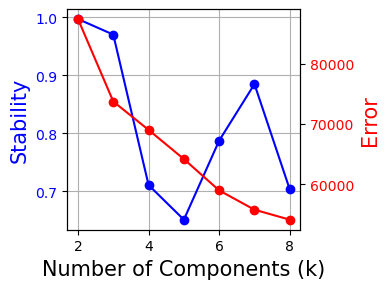

In [45]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [46]:
diamandis.get_usages()

2                       3                           \
                   1           2           1           2            3   
sample_1   286000.22  68323.9840  275952.720  52479.6600   34807.9700   
sample_10  275105.94  43376.1900  224664.500  31299.6930   66133.8750   
sample_11  303777.75  47355.5080  314928.530  32671.9120   16367.4830   
sample_12  324950.90  25667.5860  351477.340  10162.8060    5365.9014   
sample_13  322366.40  10521.4220  273698.750   3210.5137   62010.8000   
...              ...         ...         ...         ...          ...   
sample_75  381290.00   4685.1514   18709.268   2204.9595  332175.0600   
sample_76  340583.38   8121.7040   70501.820   4302.6880  251564.8600   
sample_77  375791.97   5741.7285   34656.594   3853.0070  312609.8800   
sample_8   295736.38  26210.7850  304754.120  12320.8790   17709.8610   
sample_9   352910.90  24474.2830  359701.900  11819.1110   20406.8670   

                    4                                                 5  ...  \
                    1           2            3            4           1  ...   
sample_1   185139.620  38884.5300   21769.7400  131569.5300  137678.580  ...   
sample_10  160394.620  22346.7970   53962.8360   94204.9450  134538.480  ...   
sample_11  291880.840  30637.5760   11241.3880   11249.7490  280308.620  ...   
sample_12  327816.220   9008.4860    2272.1257    7064.8135  313027.530  ...   
sample_13  234941.310   1365.5977   54966.7200   40546.5430  193631.110  ...   
...               ...         ...          ...          ...         ...  ...   
sample_75   22400.625   1348.0552  324500.3000    4750.9010   16847.957  ...   
sample_76   63391.410   2354.3203  241087.7800   20373.8900   54338.594  ...   
sample_77   40345.810   2682.2550  301493.2000    6079.7344   37932.207  ...   
sample_8   171524.700   2229.7020    4200.9100  183657.9400  120510.660  ...   
sample_9   338605.200  11112.1280   15358.7120    4818.7910  328959.720  ...   

                     7                         8                            \
                     6           7             1           2             3   
sample_1    55286.3800   7352.2180  32396.773000   55919.477    9869.36000   
sample_10   23460.9410   1622.8934   9961.894000   57564.742   23933.76400   
sample_11   26396.7090   6235.5450  25486.330000  223602.190    8483.36500   
sample_12  257565.2300   3358.1133   3345.613800   52416.426     791.54474   
sample_13   28543.0640   1978.3348    511.142270  142420.450   43329.27700   
...                ...         ...           ...         ...           ...   
sample_75    4959.4727   1621.0369   1319.062400   20781.390  295121.20000   
sample_76    7148.3630    889.7027   1045.501500   42085.630  217641.11000   
sample_77    6127.8680   1192.1918      4.160346   12103.393  255372.72000   
sample_8    30622.2850  14733.6370   1201.945200   68529.336     549.20090   
sample_9    70621.5900   3483.0800   9766.512000  249528.670   12964.59700   

                                                                           
                    4            5            6            7            8  
sample_1   41517.5940  204191.3300   44985.9770   7587.76370   4528.68360  
sample_10   8715.7120  177147.1600   13447.8260  65959.39000   1127.70650  
sample_11  21748.8610   15301.6000   22212.6070  20246.63500   4784.02000  
sample_12  17687.1910   15290.0340  248995.4000    316.19135   2830.60030  
sample_13  46582.6840   77481.0600   23539.9040   4868.86040   1348.63330  
...               ...          ...          ...          ...          ...  
sample_75  23071.9080    8054.6330    5150.5166   1109.97560   1364.38150  
sample_76   5373.9414   57853.1560    6065.6616   9702.19200    722.02900  
sample_77   3247.1694    1872.5134    1593.8807  74294.51000    263.00674  
sample_8   49269.6100  231659.6900   20312.5330    349.56573  10212.60100  
sample_9   12108.3270   14944.9500   66527.9450    214.36638   2209.48270  

[77 rows x 35 columns]

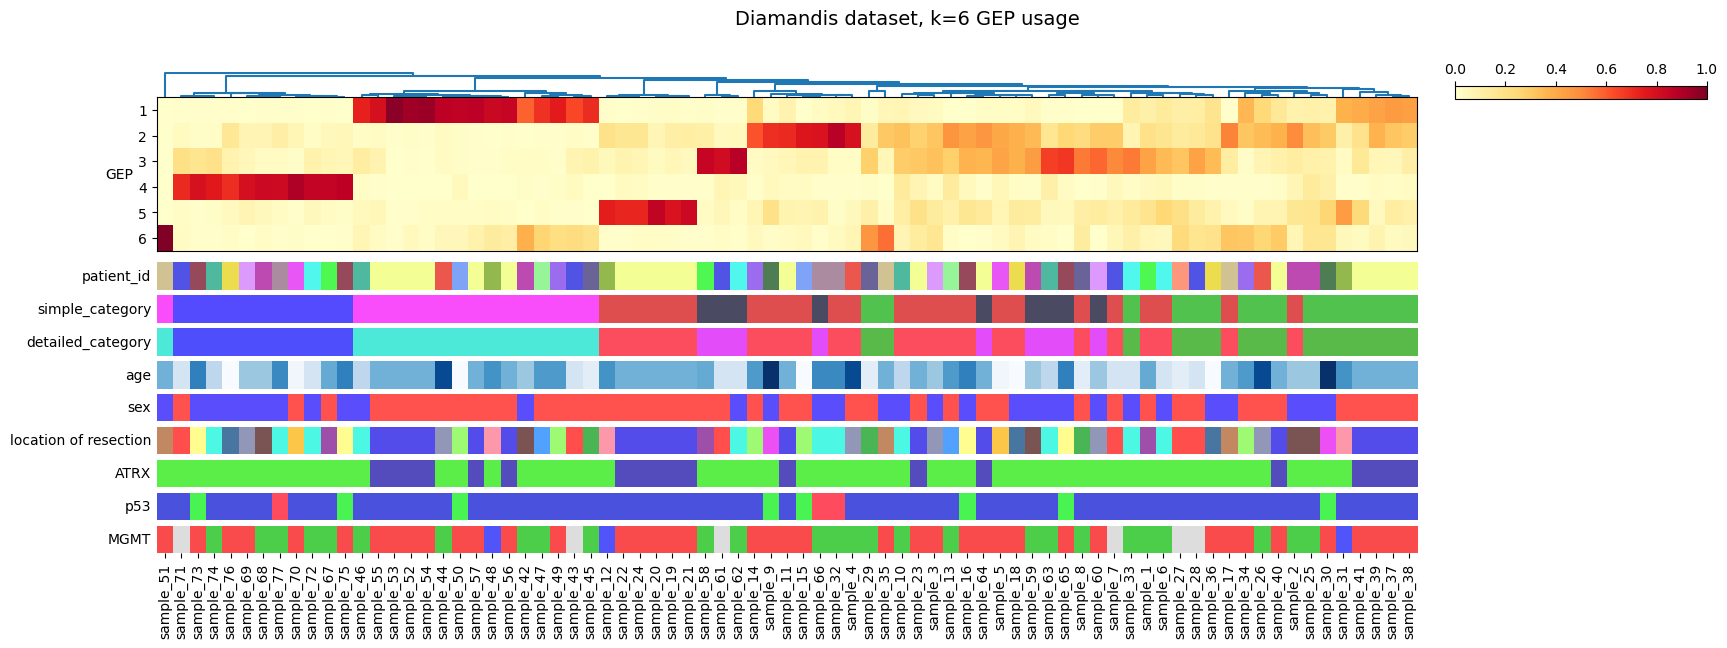

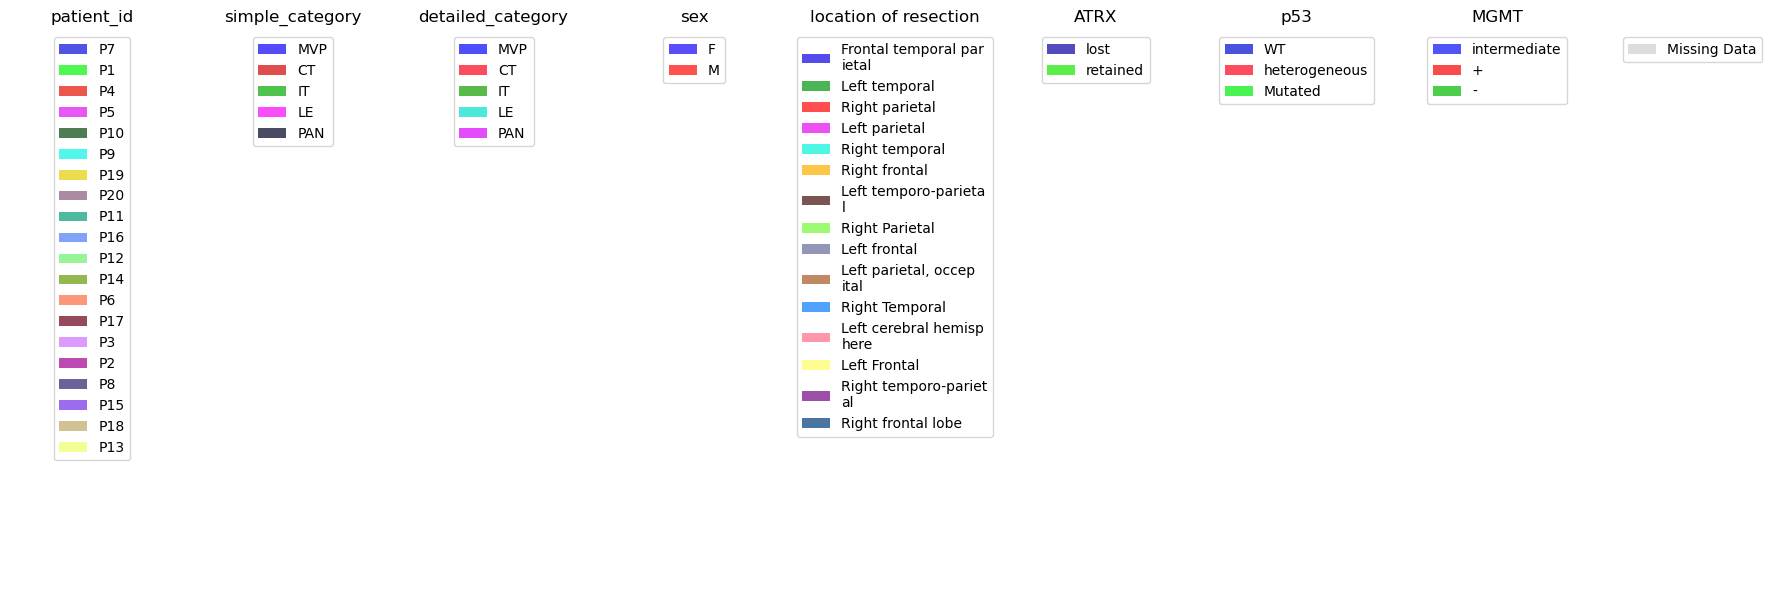

In [47]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [48]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-03-17 14:56:09,937 [INFO] 4554 genes selected for factorization
2023-03-17 15:01:33,437 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-03-17 15:01:33,440 [INFO] Merging iterations for k=2
2023-03-17 15:01:33,448 [INFO] Combining factorizations for k=2.
2023-03-17 15:01:33,601 [INFO] Merging iterations for k=3
2023-03-17 15:01:33,606 [INFO] Combining factorizations for k=3.
2023-03-17 15:01:33,710 [INFO] Merging iterations for k=4
2023-03-17 15:01:33,714 [INFO] Combining factorizations for k=4.
2023-03-17 15:01:33,831 [INFO] Merging iterations for k=5
2023-03-17 15:01:33,835 [INFO] Combining factorizations for k=5.
2023-03-17 15:01:33,969 [INFO] Merging iterations for k=6
2023-03-17 15:01:33,973 [INFO] Combining factorizations for k=6.
2023-03-17 15:01:34,117 [INFO] Merging iterations for k=7
2023-03-17 15:01:34,120 [INFO] Combining factorizations for k=7.
2023-03-17 15:01:34,273 [INFO] Merging iterations fo

# TODO: Why is this necessary?

In [50]:
print(diamandis.patient_id_col)
print(cptac.patient_id_col)

patient_id
patient_id


## Integrate multiple datasets together

In [51]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-03-17 15:20:00,083 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-03-17 15:20:00,760 [INFO] Choosing distinct dataset colors
2023-03-17 15:20:00,779 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-17 15:20:05,258 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-17 15:20:05,272 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-17 15:20:05,287 [INFO] Choosing distinct colors for metadata layer multiomic
2023-03-17 15:20:05,304 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-03-17 15:20:05,320 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-03-17 15:20:05,352 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-03-17 15:20:05,410 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-03-17 15:20:05,418 [INFO] Choosing distinct colors for metadata layer immune
2023-03-17 15:20:05,439 [INFO] Choosing di

In [52]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

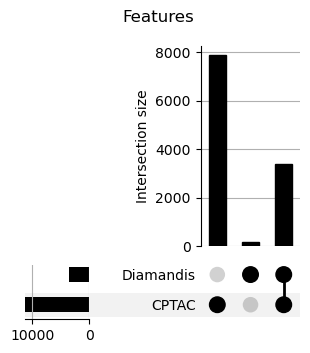

In [53]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

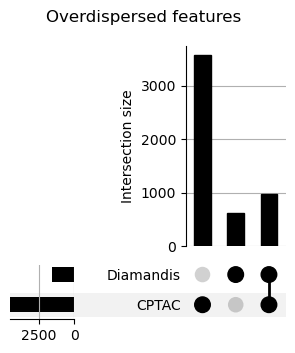

In [54]:
cn.plot_overdispersed_features_upset(integration)

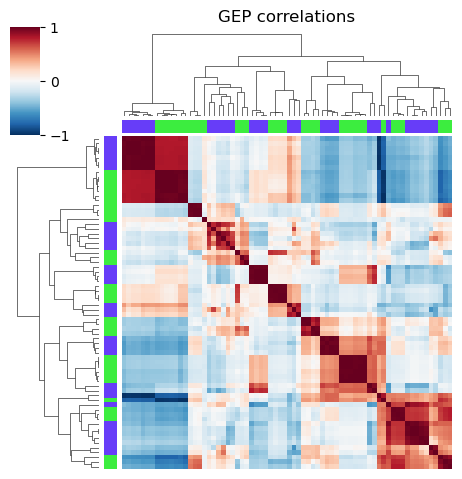

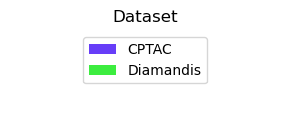

In [55]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [56]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991562    297194.531250       True   
3        True              True         -0.459577    271650.687500       True   
4        True              True         -0.363215    256502.109375       True   
5        True              True         -0.187203    241645.187500       True   
6        True              True         -0.174598    233063.687500       True   
7        True              True         -0.152134    230078.281250       True   
8        True              True         -0.127819    220542.531250       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.992330        True              True         -0.999231     87358.015625   
3  0.923791        True              True         -0.437725     73715.007812   
4  0.643736        True              True         -0.184702     69018.781250   
5  0.652330        True              True         -0.163915     64193.242188   
6  0.630983        True              True         -0.154684     59006.406250   
7  0.476522        True              True         -0.128671     55817.171875   
8  0.438222        True              True         -0.109678     54164.312500   

                        
  selected_k stability  
2       True  0.996608  
3       True  0.969817  
4       True  0.711021  
5       True  0.651464  
6       True  0.787485  
7       True  0.884702  
8       True  0.703535

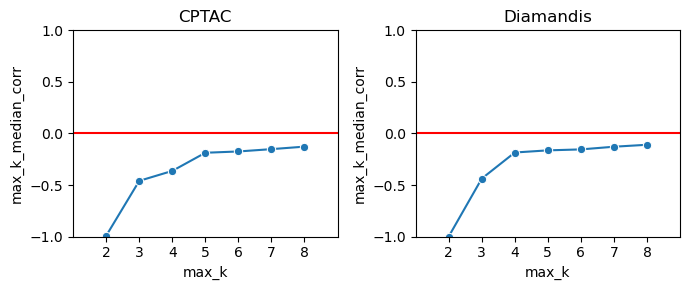

In [57]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

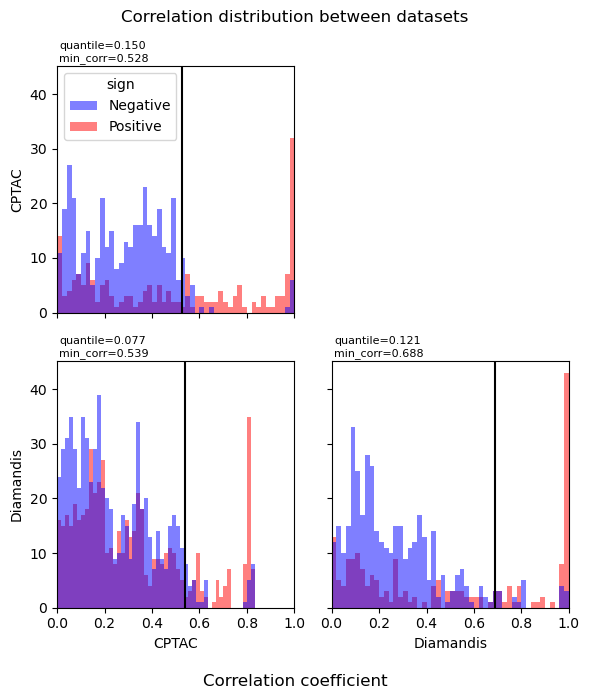

In [58]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [59]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-03-17 15:20:14,192 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-03-17 15:20:14,245 [INFO] Creating community network


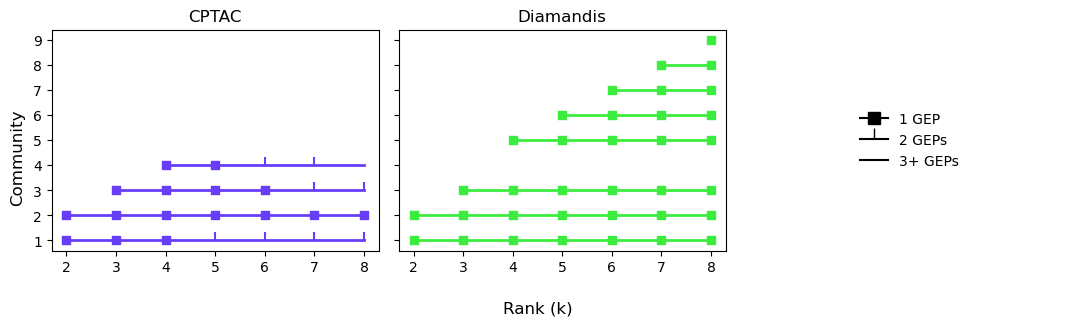

In [60]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

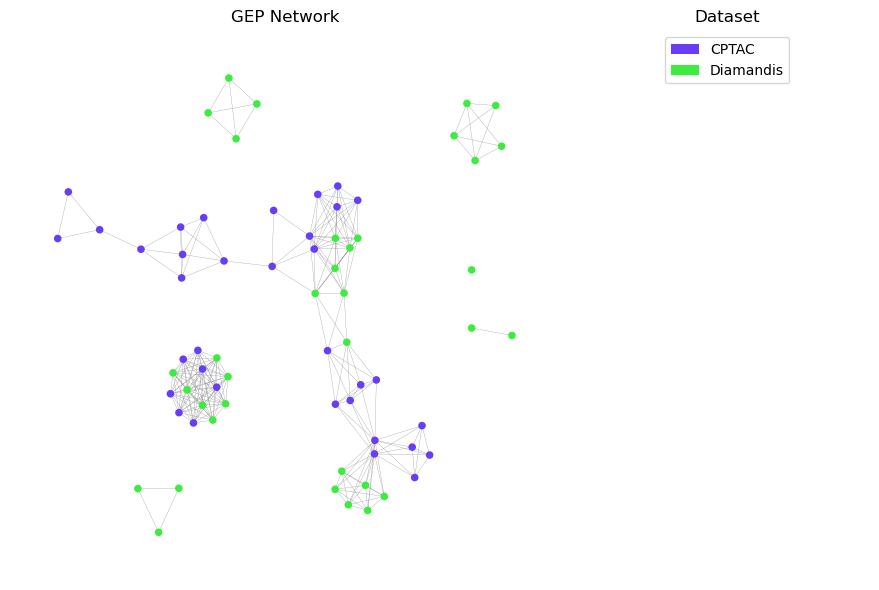

In [70]:
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

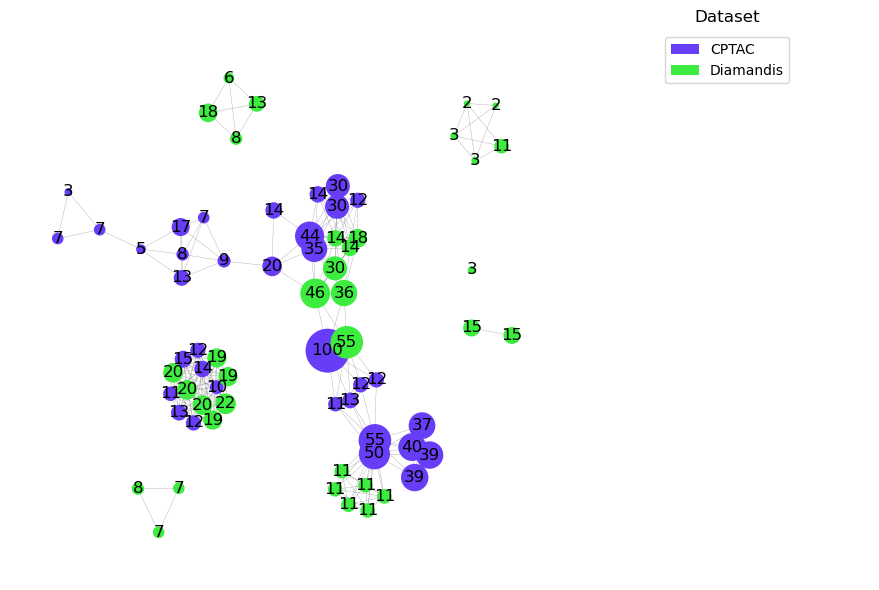

In [67]:
fig = cn.plot_gep_network_nsamples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

ValueError: multiple levels only valid with MultiIndex

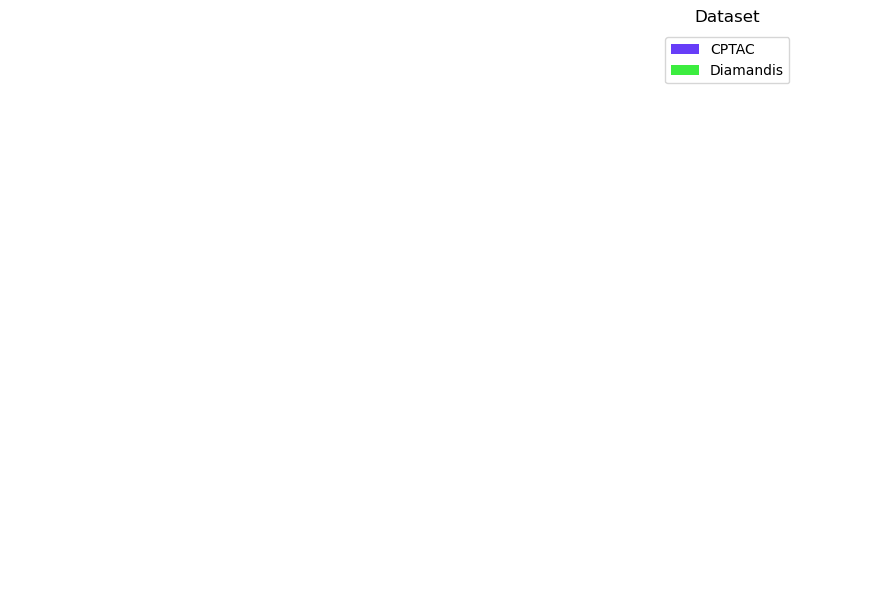

In [71]:
fig = cn.plot_gep_network_npatients(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

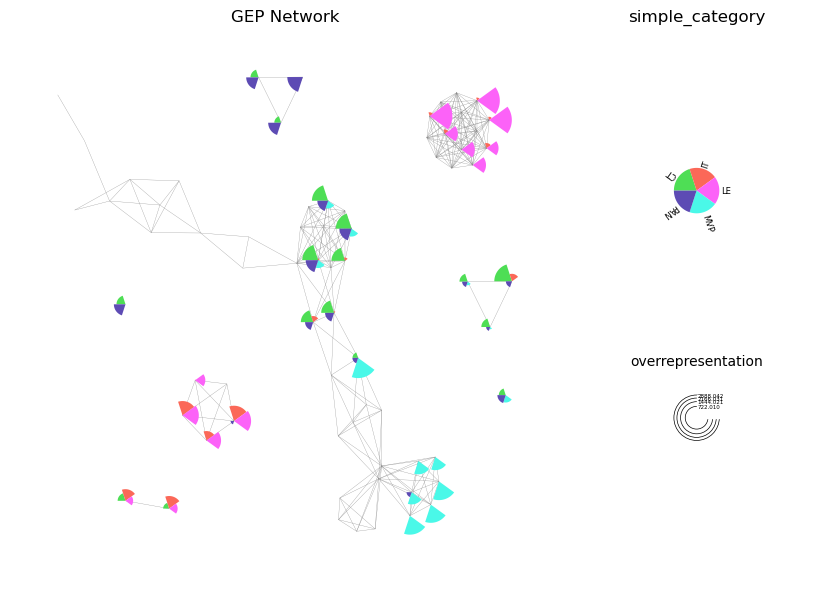

In [ ]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

In [ ]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

AttributeError: module 'cnmfsns' has no attribute 'plot_gep_overrepresentation_network'

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-03-07 21:03:17,756 [INFO] Choosing distinct community colors


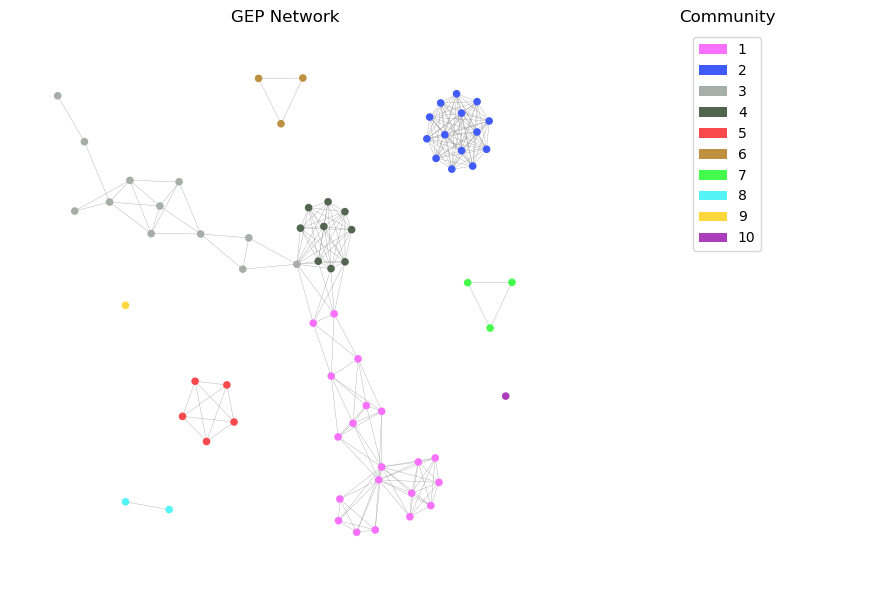

In [ ]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

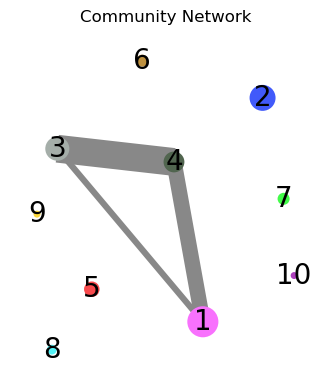

In [ ]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

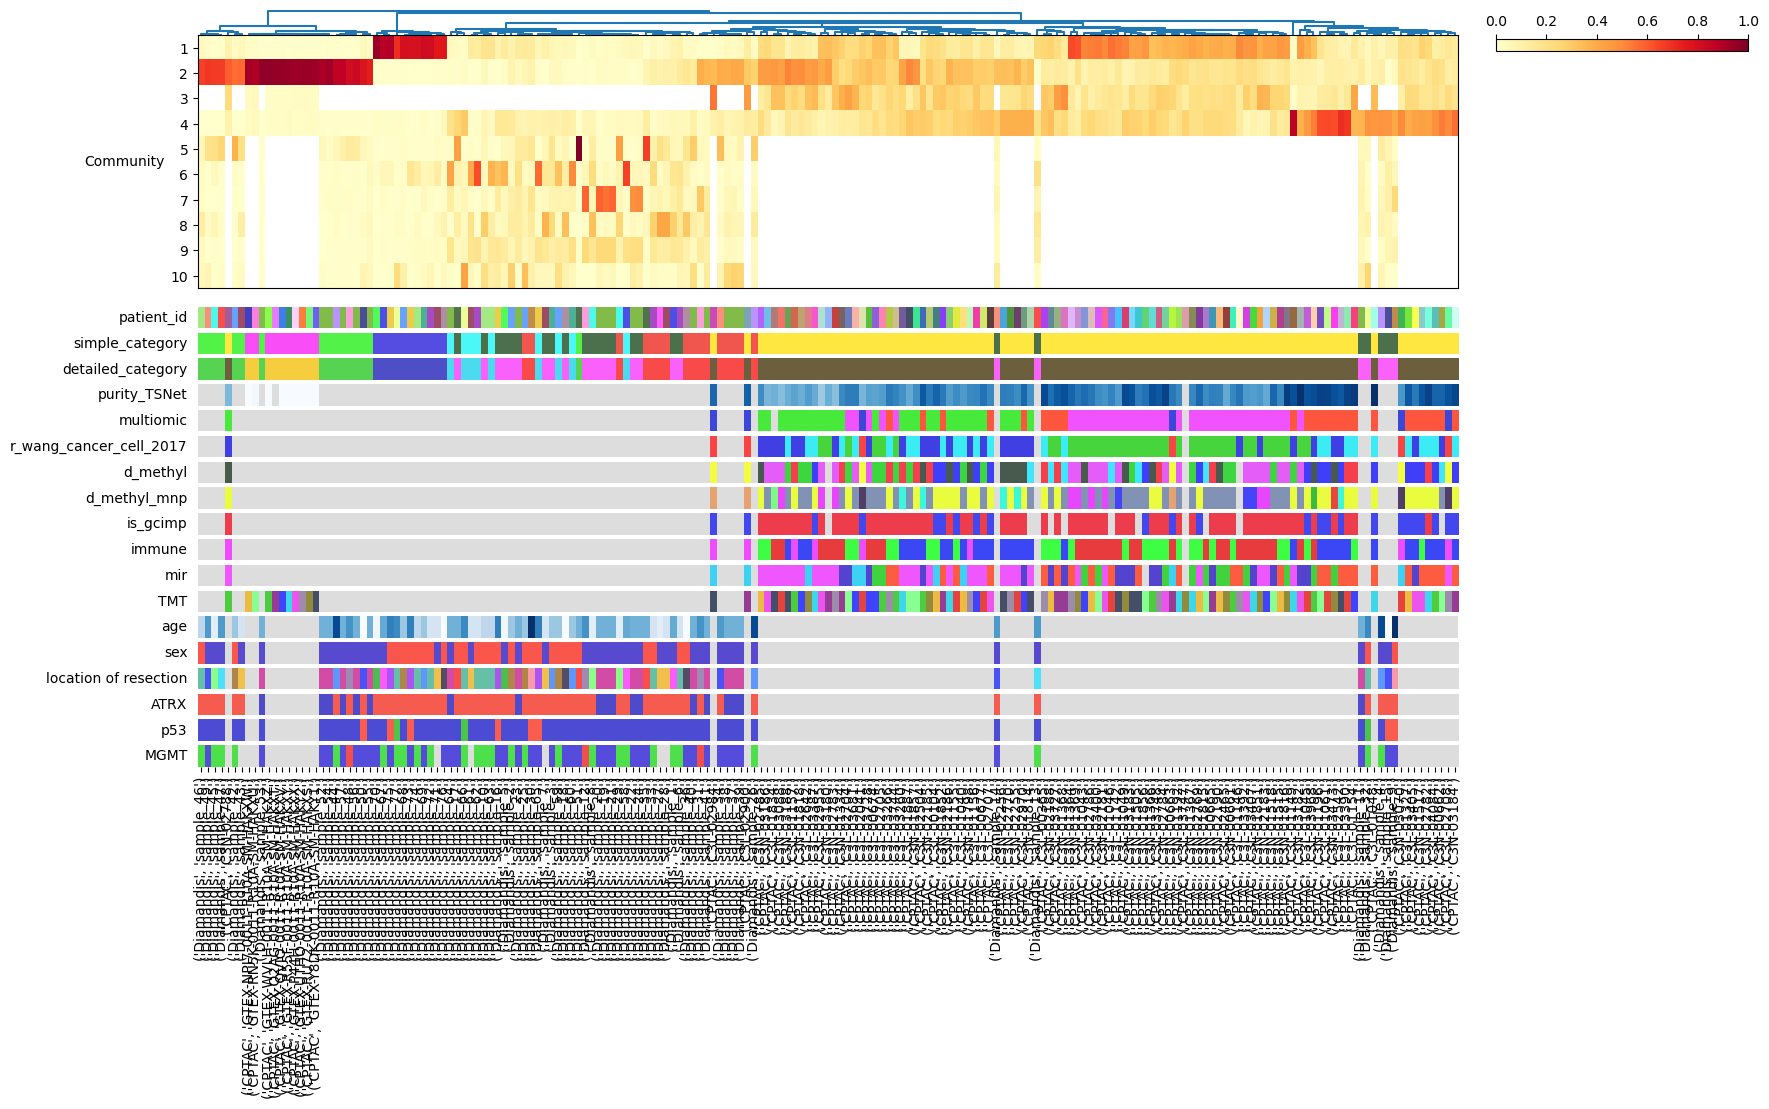

In [ ]:
fig = cn.plot_community_usage_heatmap(snsmap, colors)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

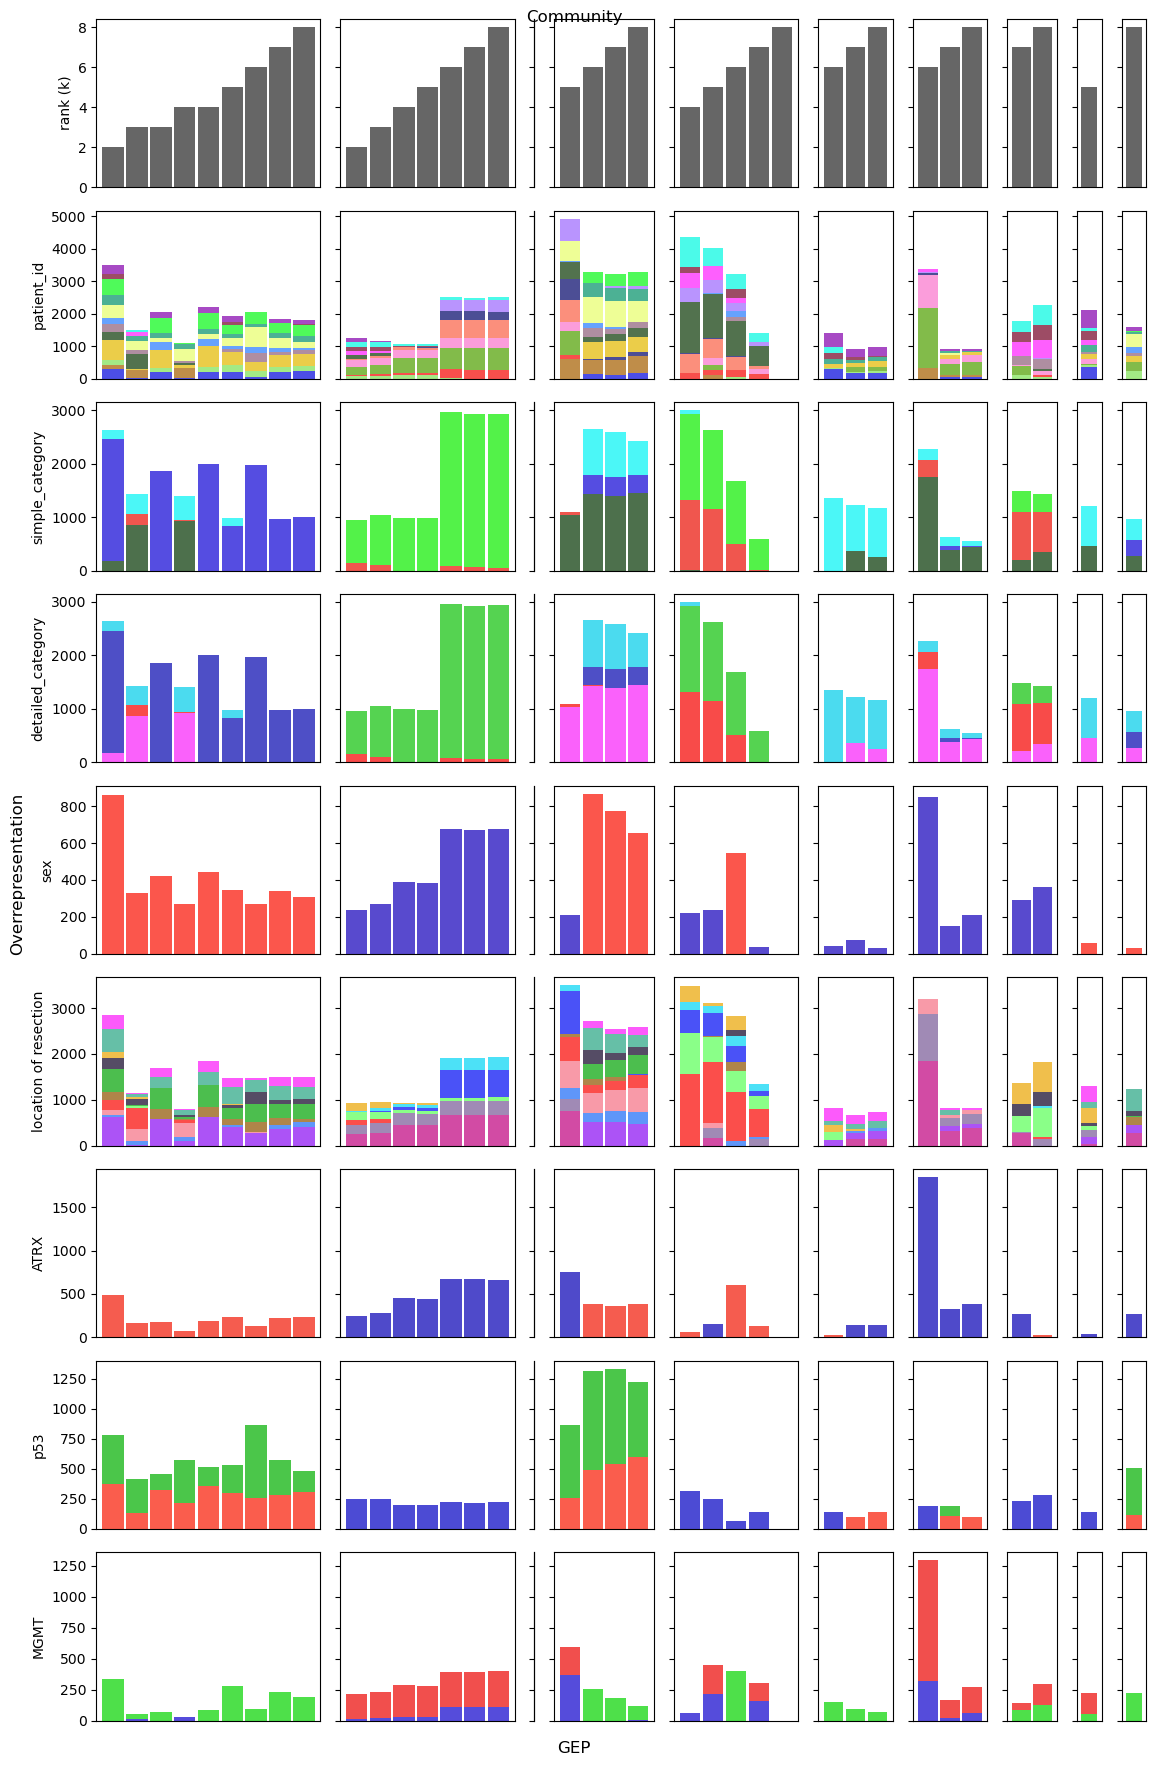

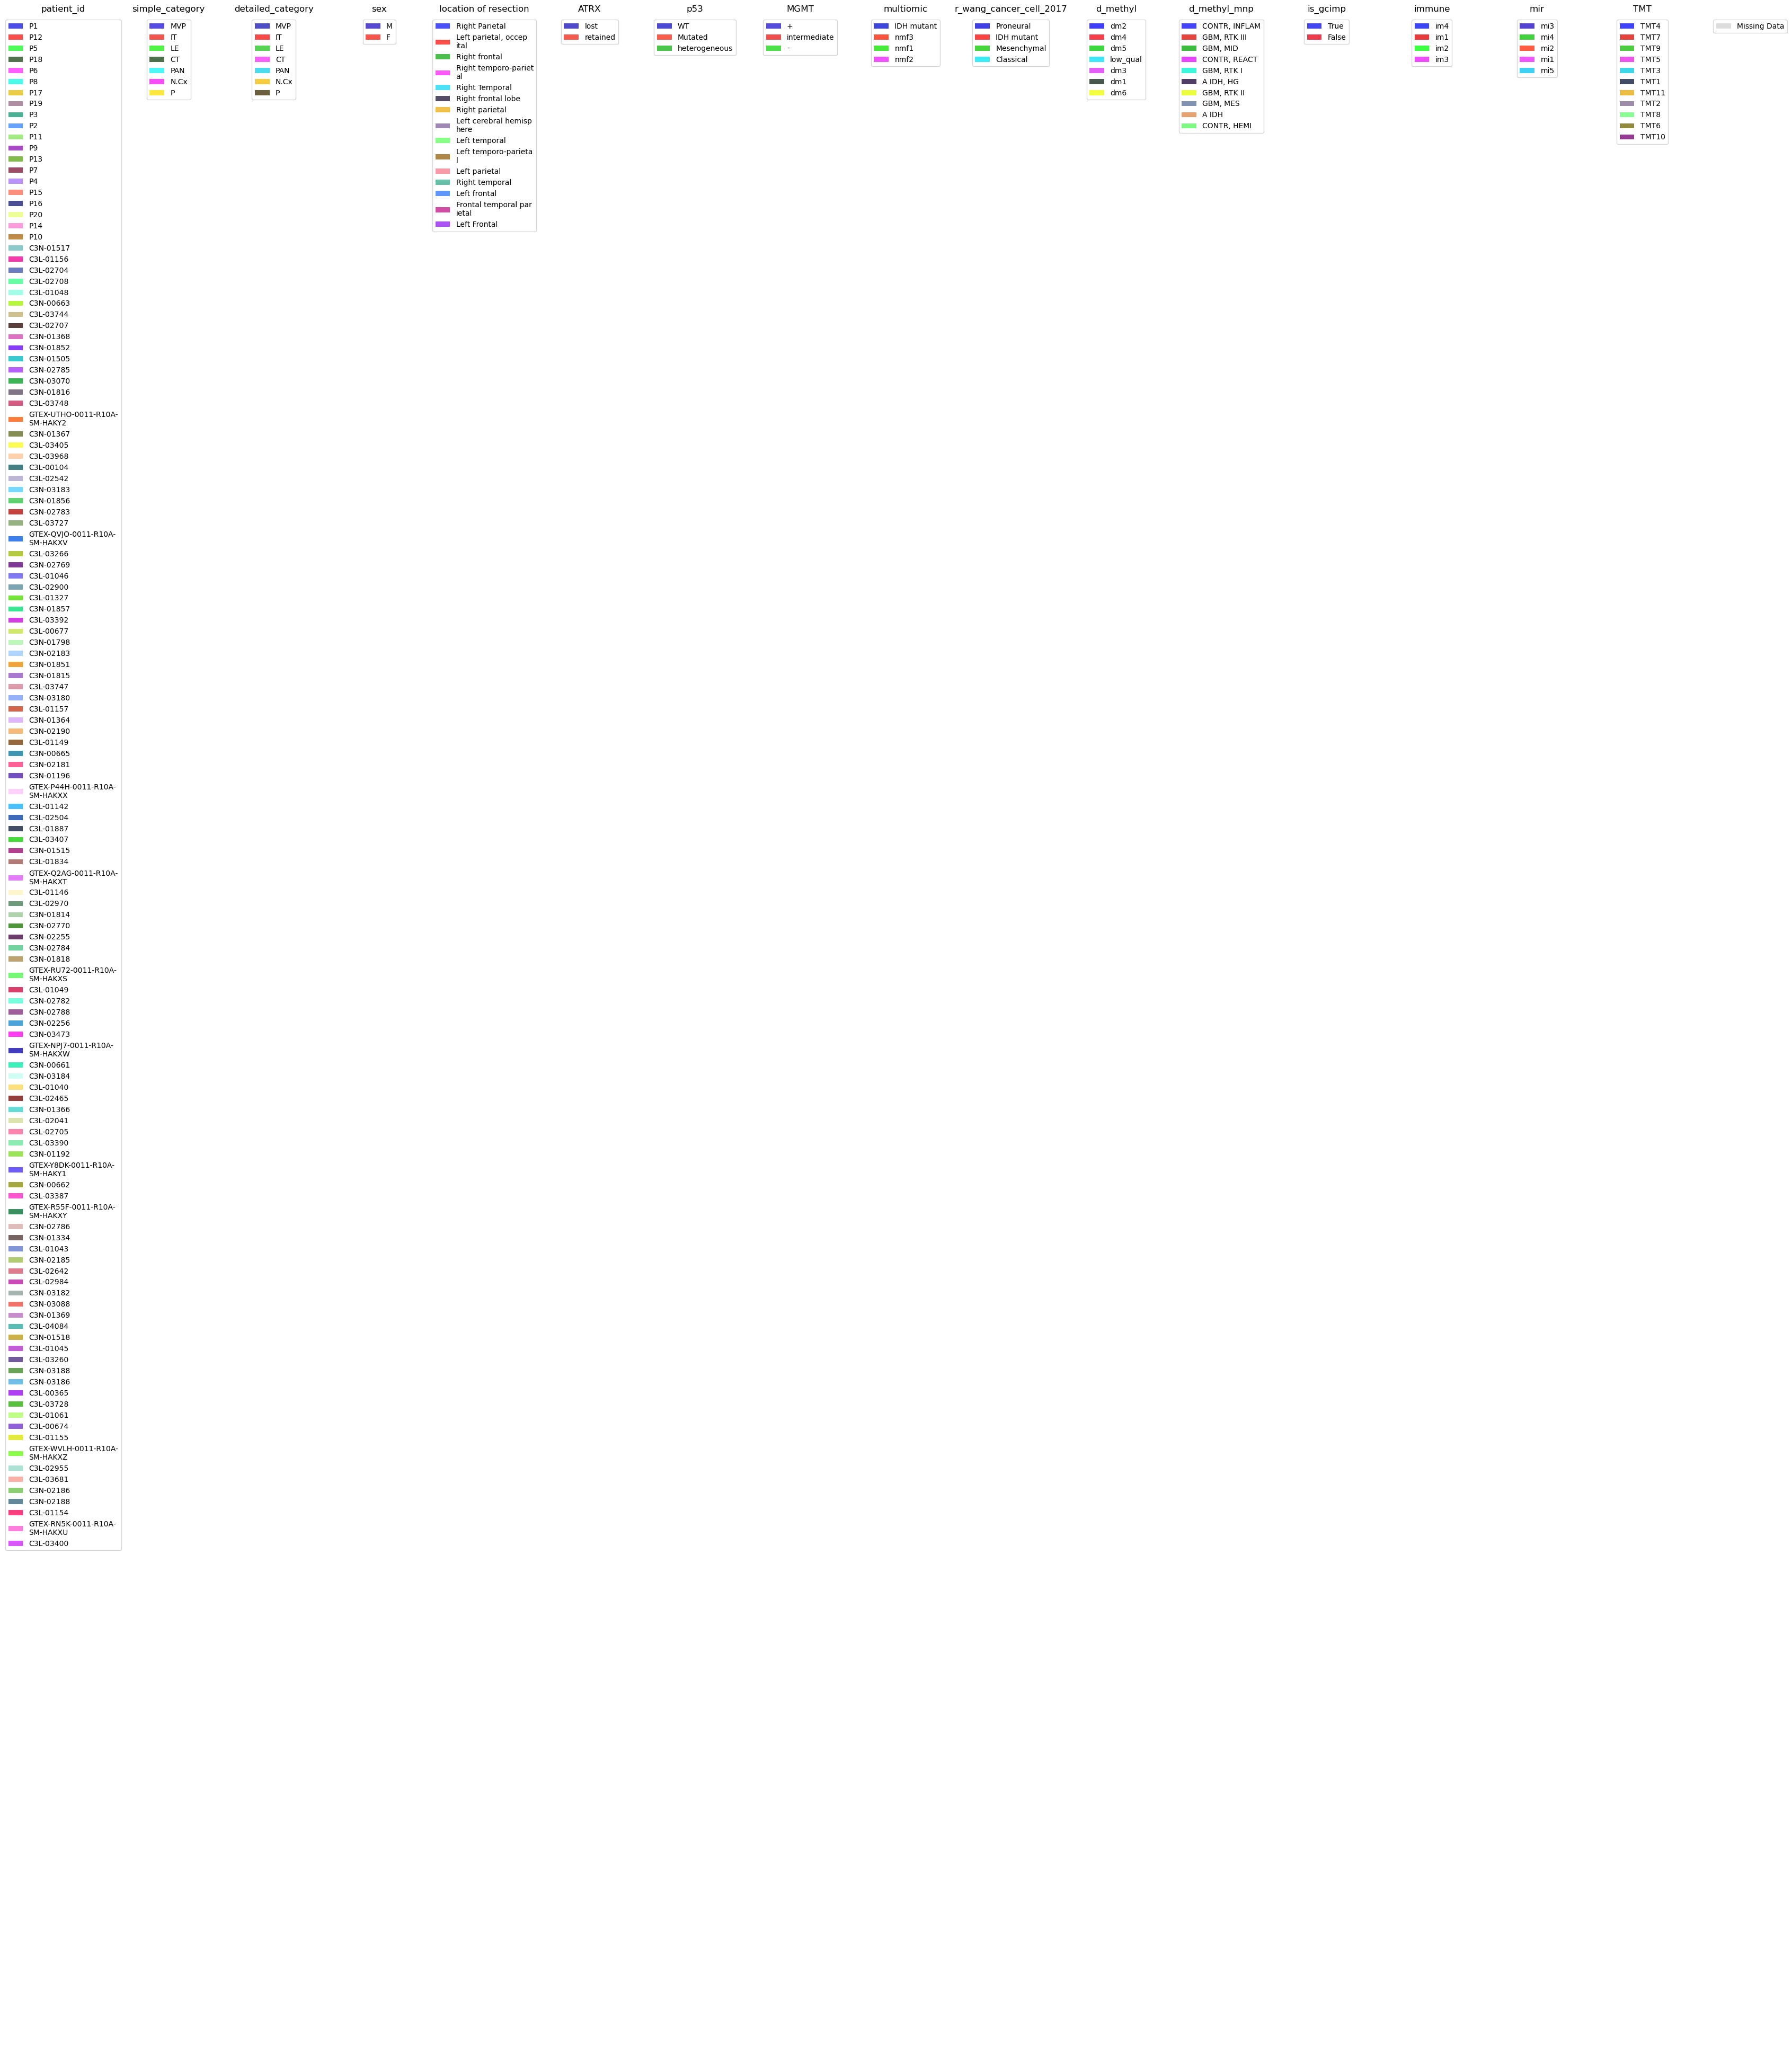

In [ ]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

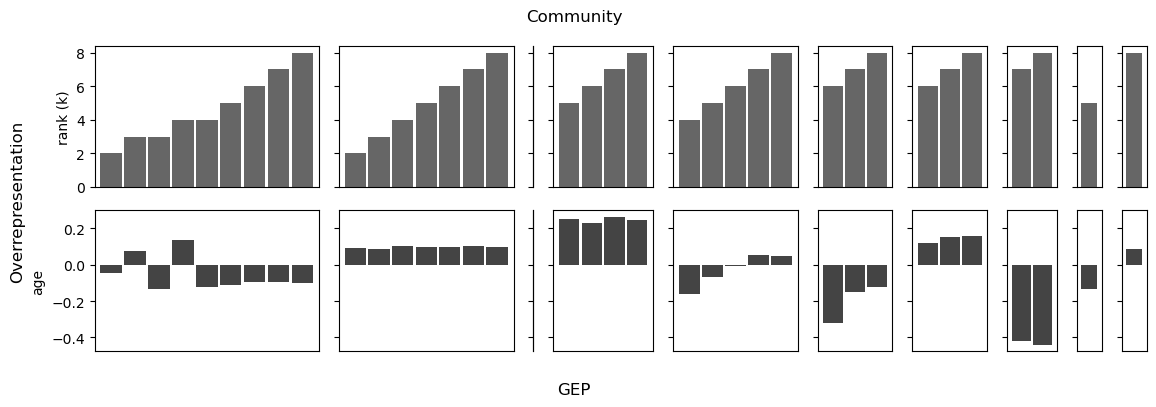

In [ ]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

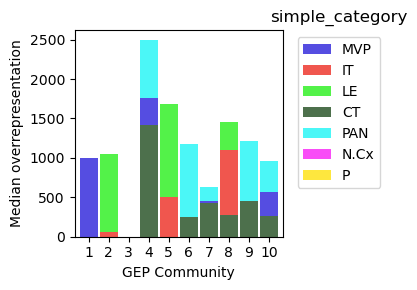

In [ ]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

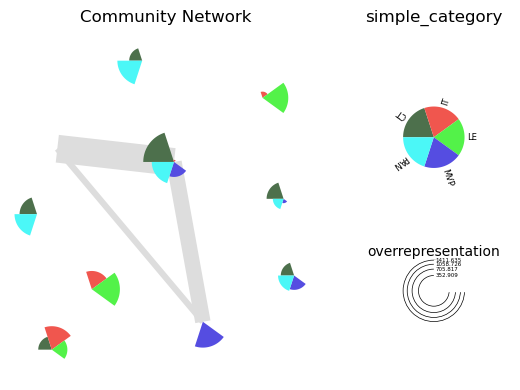

In [ ]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

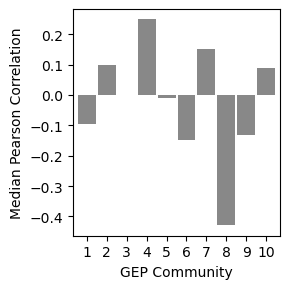

In [ ]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

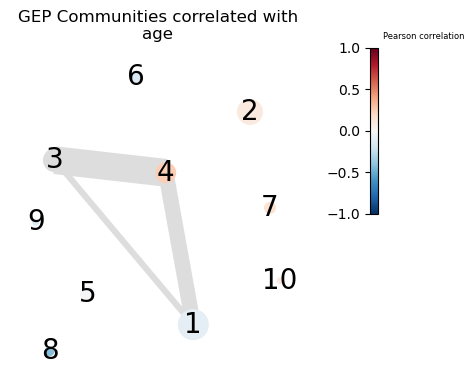

In [ ]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

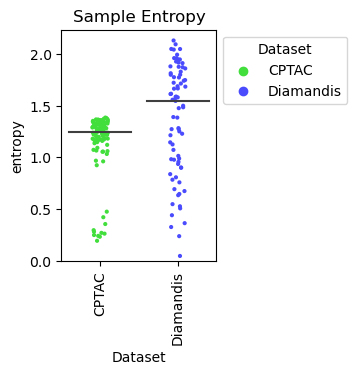

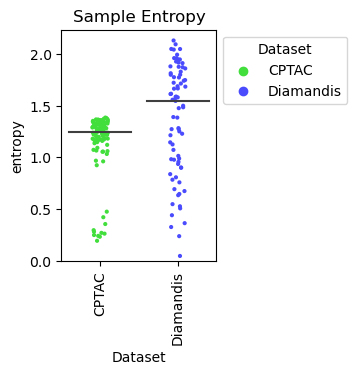

In [ ]:
cn.plot_sample_entropy(snsmap, colors)